In [1]:
import torch
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
raw_atlas = pd.read_csv('../data/processed/processed_atlas_2019.csv')
print(f'Column amt: {len(raw_atlas.columns)}')

Column amt: 21


In [4]:
raw_atlas.head()

,Unnamed: 0,CensusTract,Urban,PovertyRate,MedianFamilyIncome,TractLOWI,TractKids,TractSeniors,TractHUNV,TractSNAP,...,lakids1share,laseniors1share,lahunv1share,lalowi1share,Pop2010,LOWIRatio,SNAPRatio,HUNVRatio,FoodInsecurityIndex,LOWIWeighted
0,0,0.000000e+00,1.0,0.113,0.318183,0.036220,0.042803,0.012796,0.000990,0.046897,...,0.289978,0.1144,0.0079,0.2411,0.051027,0.007051,0.022840,0.000292,0.008725,0.006762
1,1,1.816698e-09,1.0,0.179,0.187881,0.063843,0.051161,0.012391,0.014689,0.071724,...,0.205837,0.0583,0.0900,0.2783,0.057916,0.010951,0.030778,0.003815,0.014296,0.018882
2,2,3.633395e-09,1.0,0.150,0.242867,0.103964,0.075475,0.025418,0.016339,0.079080,...,0.135903,0.0596,0.0000,0.1418,0.090038,0.011472,0.021832,0.002730,0.013853,0.025766
3,3,5.450093e-09,1.0,0.028,0.275182,0.073396,0.085690,0.052342,0.003466,0.045057,...,0.086894,0.0539,0.0046,0.0783,0.117086,0.006229,0.009566,0.000445,0.007032,0.003395
4,4,7.266791e-09,1.0,0.152,0.379128,0.178475,0.266948,0.065196,0.037960,0.155862,...,0.073128,0.0336,0.0135,0.0545,0.287442,0.006170,0.013481,0.001987,0.007736,0.044822


In [20]:
input_columns = [
    'Urban', 'PovertyRate', 'MedianFamilyIncome', 'TractLOWI', 'TractKids', 'TractSeniors',
    'TractHUNV', 'TractSNAP', 'lapop1share', 'laseniors1share', 'lahunv1share', 'lasnap1share',
    'Pop2010', 'LOWIRatio', 'SNAPRatio', 'HUNVRatio', 'FoodInsecurityIndex',
    'SNAPDisparity', 'LOWIWeighted' 
]

In [21]:
class Autoencoder_Food_Desert_Model(nn.Module):
    def __init__(self, input_dim=22, latent_dim=8):
        super(Autoencoder_Food_Desert_Model, self).__init__()
        
        #Encode our dimensions
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(True),
            nn.Linear(16, 12),
            nn.ReLU(True),
            nn.Linear(12, latent_dim)
        )
        
        #Decoding these dimensions
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 12),
            nn.ReLU(True),
            nn.Linear(12, 16),
            nn.ReLU(True),
            nn.Linear(16, input_dim),
            nn.Sigmoid()
        )

    def forward(self, input):
        encoding_result = self.encoder(input)
        decoding_output = self.decoder(encoding_result)
        return decoding_output


In [22]:
atlas_tensor = torch.tensor(raw_atlas[input_columns].to_numpy(), dtype=torch.float32)
atlas_tensor.shape

torch.Size([72531, 19])

In [23]:
print(torch.min(atlas_tensor), torch.max(atlas_tensor))

tensor(0.) tensor(1.)


In [24]:
train_size = int(0.9 * len(atlas_tensor))
val_size = len(atlas_tensor) - train_size
train_dataset, val_dataset = random_split(atlas_tensor, [train_size, val_size])

In [25]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [28]:
model = Autoencoder_Food_Desert_Model(input_dim=19, latent_dim=8).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 50

In [29]:
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for batch in train_loader:
        inputs = batch[0].to(device)
        outputs = model(inputs)
        loss = criterion(outputs, inputs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            inputs = batch[0].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            val_loss += loss.item() * inputs.size(0)
                
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss/len(train_loader.dataset):.6f} | Val Loss: {val_loss/len(val_loader.dataset):.6f}")

Epoch 1/50 | Train Loss: 0.008675 | Val Loss: 0.004798
Epoch 2/50 | Train Loss: 0.003157 | Val Loss: 0.001677
Epoch 3/50 | Train Loss: 0.001413 | Val Loss: 0.001384
Epoch 4/50 | Train Loss: 0.001219 | Val Loss: 0.001116
Epoch 5/50 | Train Loss: 0.000911 | Val Loss: 0.001032
Epoch 6/50 | Train Loss: 0.000784 | Val Loss: 0.000753
Epoch 7/50 | Train Loss: 0.000672 | Val Loss: 0.000627
Epoch 8/50 | Train Loss: 0.000633 | Val Loss: 0.000609
Epoch 9/50 | Train Loss: 0.000609 | Val Loss: 0.000617
Epoch 10/50 | Train Loss: 0.000604 | Val Loss: 0.000597
Epoch 11/50 | Train Loss: 0.000657 | Val Loss: 0.000583
Epoch 12/50 | Train Loss: 0.000581 | Val Loss: 0.000551
Epoch 13/50 | Train Loss: 0.000590 | Val Loss: 0.000535
Epoch 14/50 | Train Loss: 0.000549 | Val Loss: 0.000528
Epoch 15/50 | Train Loss: 0.000521 | Val Loss: 0.000476
Epoch 16/50 | Train Loss: 0.000504 | Val Loss: 0.000448
Epoch 17/50 | Train Loss: 0.000459 | Val Loss: 0.000426
Epoch 18/50 | Train Loss: 0.000388 | Val Loss: 0.000394
E

In [30]:
model.eval()
with torch.no_grad():
    latent_vectors = model.encoder(atlas_tensor.to(device)).cpu().numpy()

In [31]:
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(latent_vectors)

In [32]:
clustered_df = raw_atlas.copy()
clustered_df['Cluster'] = cluster_labels

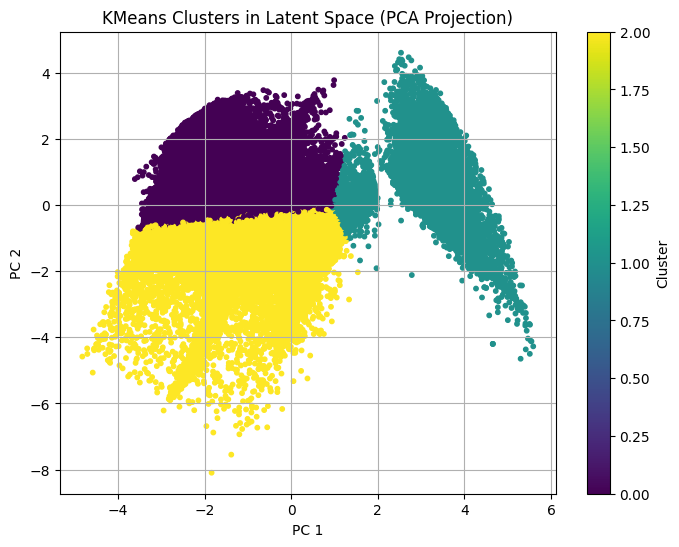

In [34]:
pca = PCA(n_components=2)
latent_2d = pca.fit_transform(latent_vectors)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=cluster_labels, cmap='viridis', s=10)
plt.title('KMeans Clusters in Latent Space (PCA Projection)')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.show()

In [35]:
clustered_df.groupby('Cluster').mean(numeric_only=True)[['PovertyRate', 'SNAPRatio', 'LOWIRatio', 'FoodInsecurityIndex']]

,PovertyRate,SNAPRatio,LOWIRatio,FoodInsecurityIndex
Cluster,,,,
0,0.203763,0.030147,0.012642,0.016258
1,0.142494,0.020344,0.009848,0.011846
2,0.067773,0.008219,0.005253,0.006733


In [36]:
clustered_df.to_csv('../data/processed/clustered_atlas_data.csv', index=False)